In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

2024-09-10 06:28:28.089612: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 06:28:28.089773: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 06:28:28.245043: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
#load from data folders
# Paths to the dataset folders
train_dir = '/kaggle/input/firedataset-jpg-224/FireDataset-V6-JPG-Reshaped224/train'
val_dir = '/kaggle/input/firedataset-jpg-224/FireDataset-V6-JPG-Reshaped224/val'
test_dir = '/kaggle/input/firedataset-jpg-224/FireDataset-V6-JPG-Reshaped224/test'

# ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerator for validation and test (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 4014 images belonging to 2 classes.
Found 492 images belonging to 2 classes.
Found 524 images belonging to 2 classes.


In [68]:
def count_files(directory):
    try:
        files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
        return len(files)
    except FileNotFoundError:
        print("Directory not found.")
        return None

In [ ]:
directory = '/kaggle/input/firedataset-jpg-224/FireDataset-V6-JPG-Reshaped224/train/fire'
print("fire images:", count_files(directory))
directory = '/kaggle/input/firedataset-jpg-224/FireDataset-V6-JPG-Reshaped224/train/non_fire'
print("Non- fire images:", count_files(directory))

In [16]:
base_model = VGG16(input_shape=(150,150,3),include_top=False,weights='imagenet')
base_model.trainable = False
model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(.2))
model.add(Dense(1,activation=tf.nn.sigmoid))


In [17]:
checkpoint_cb =ModelCheckpoint("my_keras_model.keras", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=3, restore_best_weights=True)
model.compile(optimizer =Adam(learning_rate=1e-5),loss='binary_crossentropy', metrics=['accuracy'])
hist=model.fit(train_generator,epochs=20,validation_data=val_generator,callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 490s 4s/step - accuracy: 0.7309 - loss: 0.5229 - val_accuracy: 0.8537 - val_loss: 0.3536
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 485s 4s/step - accuracy: 0.8570 - loss: 0.3341 - val_accuracy: 0.8862 - val_loss: 0.2805
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 488s 4s/step - accuracy: 0.8862 - loss: 0.2909 - val_accuracy: 0.8902 - val_loss: 0.2655
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 487s 4s/step - accuracy: 0.9047 - loss: 0.2555 - val_accuracy: 0.8923 - val_loss: 0.2590
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 488s 4s/step - accuracy: 0.8953 - loss: 0.2594 - val_accuracy: 0.8963 - val_loss: 0.2480
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 488s 4s/step - accuracy: 0.8984 - loss: 0.2465 - val_accuracy: 0.8923 - val_loss: 0.2701
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 500s 4s/step - accuracy: 0.9186 - loss: 0.2108 - val_accuracy: 0.8943 - val_loss: 0.2464
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 486s 4s/step - accuracy: 0.8951 - loss: 0.2420 - val_accu

In [18]:
model.save('/kaggle/working/firedetect.h5')

In [ ]:
model=tf.keras.models.load_model('/kaggle/working/firedetect.h5')

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_acc:.2f}')

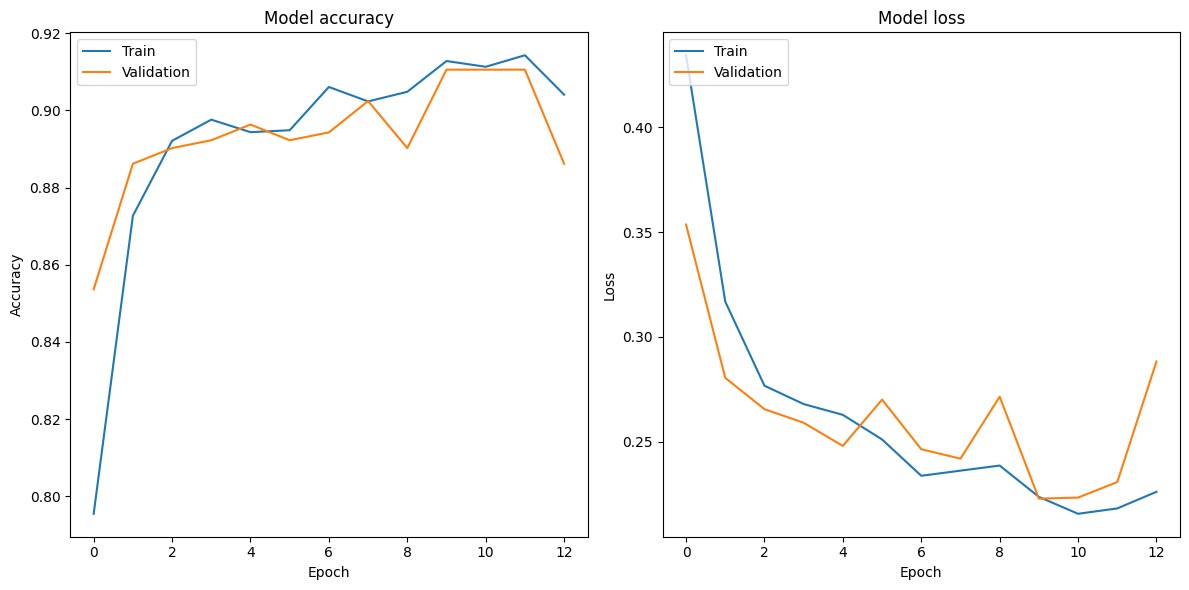

In [21]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
history=hist.history
# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


**within 13 iterations**

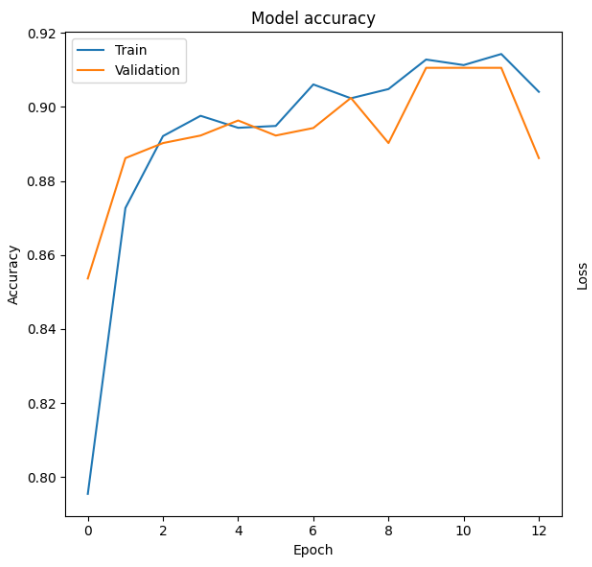
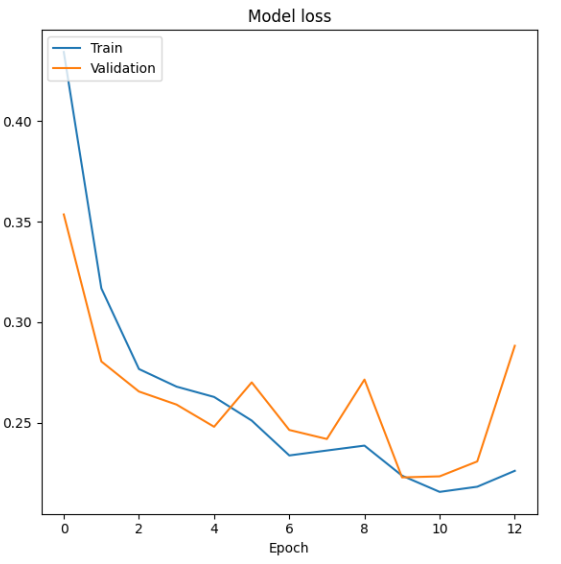